In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df_1 = pd.read_csv("../data/CSpine/CSV datasets/analysisvariables.csv")
df_2 = pd.read_csv("../data/CSpine/CSV datasets/injuryclassification.csv")
df_3 = pd.read_csv("../data/CSpine/CSV datasets/injurymechanism.csv")
target_df = pd.read_csv("../data/target.csv")

In [43]:
target_df

,StudySubjectID,CSFractures
0,110001,True
1,110002,True
2,110003,True
3,110004,True
4,110005,False
...,...,...
3309,1743310,False
3310,1743311,False
3311,1743312,False
3312,1743313,False


In [44]:
df_3.InjuryPrimaryMechanism

0        9
1       14
2       12
3        8
4        8
        ..
3309     9
3310     8
3311     9
3312     9
3313     1
Name: InjuryPrimaryMechanism, Length: 3314, dtype: object

In [61]:
target_df[target_df["CSFractures"]==True]["CSFractures"]

0       True
1       True
2       True
3       True
5       True
        ... 
3120    True
3125    True
3126    True
3128    True
3129    True
Name: CSFractures, Length: 322, dtype: bool

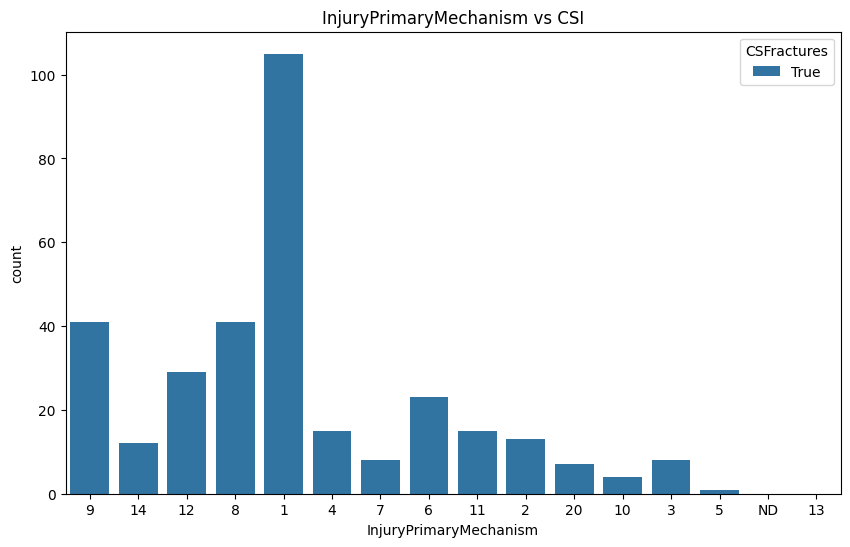

In [62]:
# Barplot of injuryprimarymechanis in df_3 with target_df CSFractures
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="InjuryPrimaryMechanism", data=df_3, hue=target_df[target_df["CSFractures"]==True]["CSFractures"])
plt.title("InjuryPrimaryMechanism vs CSI")
plt.show()

In [49]:
df_1.FocalNeuroFindings.isna().sum()

np.int64(335)

In [50]:
# Fill Nan values with 0
df_1.fillna(0, inplace=True)

In [54]:
def train_val_test_split(df, target_df, val_size=0.2, test_size=0.2, random_state=42):
    # Extract number of unique sites
    n_sites = df.SITE.nunique()
    
    # Set random seed
    np.random.seed(random_state)
    
    # Select validation sites randomly
    val_sites = np.random.choice(df.SITE.unique(), size=int(n_sites * val_size), replace=False)
    
    # Select test sites randomly from remaining sites
    remaining_sites = df.SITE.unique()[~np.isin(df.SITE.unique(), val_sites)]
    test_sites = np.random.choice(remaining_sites, size=int(n_sites * test_size), replace=False)
    
    # Split the data
    val_df = df[df.SITE.isin(val_sites)]
    test_df = df[df.SITE.isin(test_sites)]
    train_df = df[~df.SITE.isin(np.concatenate((val_sites, test_sites)))]
    
    # Split the target
    val_target = target_df[df.SITE.isin(val_sites)]
    test_target = target_df[df.SITE.isin(test_sites)]
    train_target = target_df[~df.SITE.isin(np.concatenate((val_sites, test_sites)))]
    
    # Drop columns
    train_df = train_df.drop(columns=["SITE", "CaseID", "ControlType", "StudySubjectID"])
    val_df = val_df.drop(columns=["SITE", "CaseID", "ControlType", "StudySubjectID"])
    test_df = test_df.drop(columns=["SITE", "CaseID", "ControlType", "StudySubjectID"])
    
    train_target = train_target.drop(columns=["StudySubjectID"])
    val_target = val_target.drop(columns=["StudySubjectID"])
    test_target = test_target.drop(columns=["StudySubjectID"])
    
    # Convert to numpy
    train_df = train_df.to_numpy()
    val_df = val_df.to_numpy()
    test_df = test_df.to_numpy()
    
    train_target = train_target.values.ravel()
    val_target = val_target.values.ravel()
    test_target = test_target.values.ravel()
    
    return train_df, val_df, test_df, train_target, val_target, test_target

In [55]:
train_df, val_df, test_df, train_target, val_target, test_target = train_val_test_split(df_1, target_df)

In [58]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the model
model = LogisticRegression(class_weight='balanced')

# Fit the model
model.fit(train_df, train_target)

# Predict on the validation set
val_preds = model.predict(val_df)

# Calculate the accuracy
val_accuracy = accuracy_score(val_target, val_preds)

print(f"Validation accuracy: {val_accuracy}")

# Predict on the test set
test_preds = model.predict(test_df)
test_accuracy = accuracy_score(test_target, test_preds)
print(f"Test accuracy: {test_accuracy}")



Validation accuracy: 0.6826923076923077
Test accuracy: 0.6908315565031983


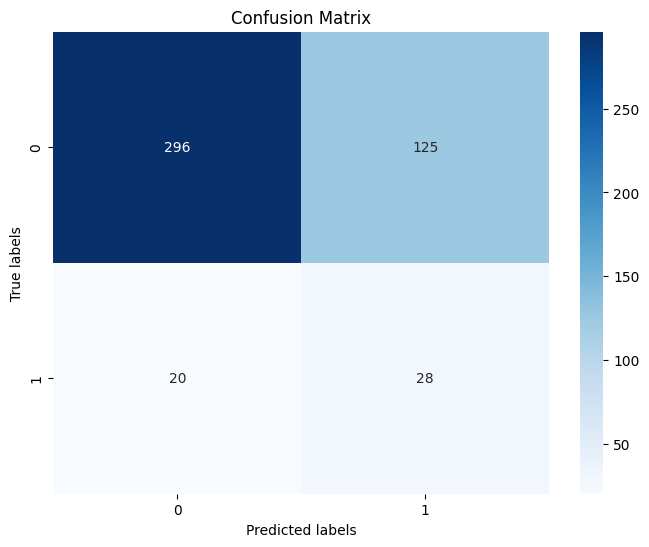

In [59]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_target, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [75]:
print(train_df.shape)

(2429, 32)


In [68]:
df_1.columns

Index(['SITE', 'CaseID', 'ControlType', 'StudySubjectID',
       'AlteredMentalStatus', 'LOC', 'ambulatory', 'FocalNeuroFindings',
       'PainNeck', 'PosMidNeckTenderness', 'TenderNeck', 'Torticollis',
       'SubInj_Head', 'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk',
       'Predisposed', 'HighriskDiving', 'HighriskFall', 'HighriskHanging',
       'HighriskHitByCar', 'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc',
       'axialloadtop', 'Clotheslining', 'AlteredMentalStatus2',
       'FocalNeuroFindings2', 'PainNeck2', 'PosMidNeckTenderness2',
       'TenderNeck2', 'Torticollis2', 'subinj_Head2', 'subinj_Face2',
       'subinj_Ext2', 'subinj_TorsoTrunk2'],
      dtype='object')

In [80]:
# Show the weights of the model
weights = np.exp(model.coef_)
weights = pd.DataFrame(weights, columns=df_1.columns[4:])


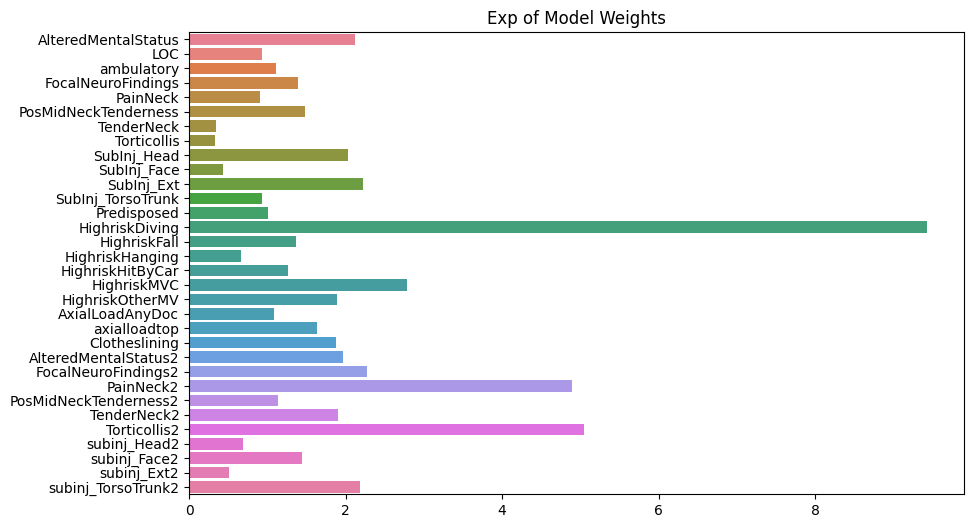

In [82]:
# Plot the weights
plt.figure(figsize=(10, 6))
sns.barplot(data=weights, orient="h")
plt.title("Exp of Model Weights")
plt.show()